

1. VGGBase - backbone модели детектирования (VGG16). 

2. AuxiliaryConvolutions - вспомогательные свертки, для увеличения карт признаков (голов), где будет решаться задача классификации и локализации. Использование нескольких карт признаков позволяет детектировать объекты на разных масштабах (`conv4_3, conv7, conv8_2, conv9_2, conv10_2, conv11_2`)

3. PredictionConvolutions - предсказывающие свертки, дополнительные слои, где решается задача классификации и локализации.

In [14]:
import os
import glob

import torch
import torchvision
import torch.nn.functional as F


import cv2
from torch import nn
from math import sqrt
import numpy as np
import collections
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont


import albumentations as A
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data

from torch.optim.lr_scheduler import ReduceLROnPlateau


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

In [2]:
torch.__version__


'1.12.1+cu113'

In [3]:
device

device(type='cuda')

In [4]:
## VGG Backbone
class VGGBase(nn.Module):
    def __init__(self):
        super(VGGBase, self).__init__()

        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)  
        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

        self.load_pretrained_layers()

    def forward(self, image):
        out = F.relu(self.conv1_1(image))
        out = F.relu(self.conv1_2(out))
        out = self.pool1(out)

        out = F.relu(self.conv2_1(out))
        out = F.relu(self.conv2_2(out))
        out = self.pool2(out)

        out = F.relu(self.conv3_1(out))
        out = F.relu(self.conv3_2(out))
        out = F.relu(self.conv3_3(out)) 
        out = self.pool3(out)

        out = F.relu(self.conv4_1(out))
        out = F.relu(self.conv4_2(out))
        out = F.relu(self.conv4_3(out))
        conv4_3_feats = out

        out = self.pool4(out)
        out = F.relu(self.conv5_1(out))
        out = F.relu(self.conv5_2(out))
        out = F.relu(self.conv5_3(out))
        out = self.pool5(out)           
        out = F.relu(self.conv6(out))   
        conv7_feats = F.relu(self.conv7(out))

        return conv4_3_feats, conv7_feats

    def load_pretrained_layers(self):
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())

        pretrained_state_dict = torchvision.models.vgg16(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        for i, param in enumerate(param_names[:-4]): 
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']
        
        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3]) 
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])
        
        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias'] 

        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None]) 
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])

        self.load_state_dict(state_dict)

        print("\n Loaded backbone.\n")

def decimate(tensor, m):
    assert tensor.dim() == len(m)
    for d in range(tensor.dim()):
        if m[d] is not None:
            tensor = tensor.index_select(dim=d, index=torch.arange(start=0, end=tensor.size(d), step=m[d]).long())
    return tensor

In [5]:
class AuxiliaryConvolutions(nn.Module):
    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()
        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0) 
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)

    def forward(self, conv7_feats):
        out = F.relu(self.conv8_1(conv7_feats)) 
        out = F.relu(self.conv8_2(out))  
        conv8_2_feats = out 

        out = F.relu(self.conv9_1(out))
        out = F.relu(self.conv9_2(out)) 
        conv9_2_feats = out 

        out = F.relu(self.conv10_1(out)) 
        out = F.relu(self.conv10_2(out))
        conv10_2_feats = out  

        out = F.relu(self.conv11_1(out))
        out = F.relu(self.conv11_2(out))
        conv11_2_feats = out

        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats


class PredictionConvolutions(nn.Module):
    def __init__(self, n_classes, head_to_use=['4', '7', '82', '9_2', '10_2', '11_2']):
        super(PredictionConvolutions, self).__init__()
        self.n_classes = n_classes
        self.head_to_use = head_to_use

        n_boxes = {'conv4_3': 4, 'conv7': 6, 'conv8_2': 6,
                   'conv9_2': 6, 'conv10_2': 4, 'conv11_2': 4}

        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 4, kernel_size=3, padding=1)

        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * self.n_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * self.n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * self.n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * self.n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * self.n_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * self.n_classes, kernel_size=3, padding=1)

    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        batch_size = conv4_3_feats.size(0)

        if '4' in self.head_to_use:
            l_conv4_3 = self.loc_conv4_3(conv4_3_feats) 
            l_conv4_3 = l_conv4_3.permute(0, 2, 3, 1).contiguous()
            l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)

            c_conv4_3 = self.cl_conv4_3(conv4_3_feats)
            c_conv4_3 = c_conv4_3.permute(0, 2, 3, 1).contiguous()
            c_conv4_3 = c_conv4_3.view(batch_size, -1, self.n_classes)

        if '7' in self.head_to_use:
            l_conv7 = self.loc_conv7(conv7_feats)
            l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()
            l_conv7 = l_conv7.view(batch_size, -1, 4)

            c_conv7 = self.cl_conv7(conv7_feats)
            c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()
            c_conv7 = c_conv7.view(batch_size, -1,self.n_classes)

        if '82' in self.head_to_use:
            l_conv8_2 = self.loc_conv8_2(conv8_2_feats)
            l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()
            l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)

            c_conv8_2 = self.cl_conv8_2(conv8_2_feats)
            c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()
            c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)

        if '9_2' in self.head_to_use:
            l_conv9_2 = self.loc_conv9_2(conv9_2_feats)
            l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()
            l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)


            c_conv9_2 = self.cl_conv9_2(conv9_2_feats)
            c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()
            c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes)

        if '10_2' in self.head_to_use:
            l_conv10_2 = self.loc_conv10_2(conv10_2_feats) 
            l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()
            l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)


            c_conv10_2 = self.cl_conv10_2(conv10_2_feats)
            c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()
            c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes)

        if '11_2' in self.head_to_use:
            l_conv11_2 = self.loc_conv11_2(conv11_2_feats) 
            l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()
            l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)


            c_conv11_2 = self.cl_conv11_2(conv11_2_feats)
            c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()
            c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)


        

        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2], dim=1)

        return locs, classes_scores

In [6]:
class SSD300_(nn.Module):
    def __init__(self, n_classes):
        super(SSD300_, self).__init__()
        self.n_classes = n_classes

        self.base = VGGBase()
        self.aux_convs = AuxiliaryConvolutions()
        self.pred_convs = PredictionConvolutions(self.n_classes)

        self.priors_cxcy = self.create_prior_boxes()
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1)) 
        nn.init.constant_(self.rescale_factors, 20)

    def create_prior_boxes(self):
        fmap_dims = {'conv4_3': 38, 'conv7': 19, 'conv8_2': 10,
                     'conv9_2': 5, 'conv10_2': 3, 'conv11_2': 1}

        obj_scales = {'conv4_3': 0.1, 'conv7': 0.2, 'conv8_2': 0.375,
                      'conv9_2': 0.55, 'conv10_2': 0.725, 'conv11_2': 0.9}
        
        aspect_ratios = {'conv4_3': [1., 2., 0.5], 'conv7': [1., 2., 3., 0.5, 0.333],
                         'conv8_2': [1., 2., 3., 0.5, 0.333], 'conv9_2': [1., 2., 3., 0.5, 0.333],
                         'conv10_2': [1., 2., 0.5], 'conv11_2': [1., 2., 0.5]}

        prior_boxes = []
        fmaps = list(fmap_dims.keys())

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]): 
                for j in range(fmap_dims[fmap]): 
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])

                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)
        prior_boxes.clamp_(0, 1)
        return prior_boxes

    def forward(self, image):
      conv4_3_feats, conv7_feats = self.base(image)  

      norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()
      conv4_3_feats = conv4_3_feats / norm 
      conv4_3_feats = conv4_3_feats * self.rescale_factors  

      conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = self.aux_convs(conv7_feats)  

      locs, classes_scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, 
                                              conv10_2_feats, conv11_2_feats)

      return locs, classes_scores


    def change_num_classes(self, new_n_classes):
        self.n_classes = new_n_classes
        self.pred_convs = PredictionConvolutions(self.n_classes)

In [7]:
#Вспомогательные функции
#(x_min, y_min, x_max, y_max) -> (c_x, c_y, w, h)
def xy_to_cxcy(xy):
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h

#(c_x, c_y, w, h) -> (x_min, y_min, x_max, y_max)
def cxcy_to_xy(cxcy):
    return torch.cat([cxcy[:, :2] - (cxcy[:, 2:] / 2),  # x_min, y_min
                      cxcy[:, :2] + (cxcy[:, 2:] / 2)], 1)  # x_max, y_max

#(c_x, c_y, w, h) -> (g_c_x, g_c_y,  g_w, g_h)
def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    return torch.cat([(cxcy[:, :2] - priors_cxcy[:, :2]) / (priors_cxcy[:, 2:] / 10), 
                      torch.log(cxcy[:, 2:] / priors_cxcy[:, 2:]) * 5], 1) 

#(g_c_x, g_c_y,  g_w, g_h) -> (c_x, c_y, w, h)
def gcxgcy_to_cxcy(gcxgcy, priors_cxcy):
    return torch.cat([gcxgcy[:, :2] * priors_cxcy[:, 2:] / 10 + priors_cxcy[:, :2], 
                      torch.exp(gcxgcy[:, 2:] / 5) * priors_cxcy[:, 2:]], 1) 


def find_intersection(set_1, set_2):
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0)) 
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0) 
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1] 


def find_jaccard_overlap(set_1, set_2):
    intersection = find_intersection(set_1, set_2) 
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])

    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection 
    return intersection / union

In [8]:
class SSD300(SSD300_):
  def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)

        predicted_scores = F.softmax(predicted_scores, dim=2)

        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            decoded_locs = cxcy_to_xy(gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))

            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1) 

            for c in range(1, self.n_classes):
                class_scores = predicted_scores[i][:, c]
                score_above_min_score = class_scores > min_score 
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
 
                class_scores = class_scores[score_above_min_score] 
                class_decoded_locs = decoded_locs[score_above_min_score] 

                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  
                class_decoded_locs = class_decoded_locs[sort_ind] 

                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  

                # Non-Maximum Suppression (NMS)
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)

                for box in range(class_decoded_locs.size(0)):
                    if suppress[box] == 1:
                        continue

                    suppress = suppress | (overlap[box] > max_overlap)
                    suppress[box] = 0

                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                image_scores.append(class_scores[1 - suppress])

            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))

            image_boxes = torch.cat(image_boxes, dim=0) 
            image_labels = torch.cat(image_labels, dim=0)
            image_scores = torch.cat(image_scores, dim=0) 
            n_objects = image_scores.size(0)

            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k] 
                image_boxes = image_boxes[sort_ind][:top_k] 
                image_labels = image_labels[sort_ind][:top_k] 

            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores 

In [9]:
class MultiBoxLoss(nn.Module):
    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1., device='cuda:0'):
        super(MultiBoxLoss, self).__init__()

        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold 
        self.neg_pos_ratio = neg_pos_ratio 
        self.alpha = alpha
        self.device = device

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)

        #каждую картинку отдельно обрабатываем
        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            #закидываем на гпу
            boxes[i] = boxes[i].to(device)
            labels[i] = labels[i].to(device)

            overlap = find_jaccard_overlap(boxes[i], self.priors_xy) 
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)
            _, prior_for_each_object = overlap.max(dim=1)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)
            overlap_for_each_prior[prior_for_each_object] = 1.
            label_for_each_prior = labels[i][object_for_each_prior]
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0
            true_classes[i] = label_for_each_prior
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (8732, 4)

        positive_priors = true_classes != 0

        # LOCALIZATION LOSS
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  #scalar

        # CONFIDENCE LOSS
        n_positives = positive_priors.sum(dim=1)
        n_hard_negatives = self.neg_pos_ratio * n_positives

        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))
        conf_loss_all = conf_loss_all.view(batch_size, n_priors) 
        conf_loss_pos = conf_loss_all[positive_priors]
        conf_loss_neg = conf_loss_all.clone()
        conf_loss_neg[positive_priors] = 0.  
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)

        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]

        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()

        return conf_loss + self.alpha * loc_loss

In [10]:
#будем использовать модель предобученную на Pascal VOC, вот его классы
voc_labels = ('background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')

label_map = {k: v for v, k in enumerate(voc_labels)}
rev_label_map = {v: k for k, v in label_map.items()} 

# Color map for bounding boxes of detected objects from https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4', '#46f0f0', '#f032e6',
                   '#d2f53c', '#fabebe', '#008080', '#000080', '#aa6e28', '#fffac8', '#800000', '#aaffc3', '#808000',
                   '#ffd8b1', '#e6beff', '#808080', '#FFFFFF']
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}

# Part 1

Скачаем предобученную модель и проверим на изображении что все работает

In [11]:
ssd = SSD300(21)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]


 Loaded backbone.



In [12]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [13]:
#указываем путь к данным
data_path='/home/vitya/DataPrep/experiments/od'
checkpoint = torch.load(data_path + '/checkpoint_ssd300_pascal_voc.pth')



In [ ]:
#загружаем веса
ssd.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [ ]:
transform = transforms.Compose([to_tensor, resize, normalize])


img_path = '/content/gdrive/MyDrive/DL/mbm_rjXvz58.jpg' 

original_image = Image.open(img_path) 
img_torch = transform(original_image)



In [ ]:
locs, scores = ssd.forward(img_torch.view((1,3,300,300)))
det_boxes, det_labels, det_scores = ssd.detect_objects(locs.cuda(), scores.cuda(), 0.7, 0.3, 10)

In [ ]:
original_dims = torch.FloatTensor([original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)

det_boxes = det_boxes[0].cpu() * original_dims
det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

In [ ]:
#функция для рисования
def draw_boxes(original_image, det_boxes, det_labels):
  annotated_image = original_image.copy()
  draw = ImageDraw.Draw(annotated_image)
  font = ImageFont.load_default()

  for i in range(det_boxes.size(0)):
    # Boxes
    box_location = det_boxes[i].tolist()
    draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
    draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[det_labels[i]]) 

    # Text
    text_size = font.getsize(det_labels[i].upper())
    text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
    textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4., box_location[1]]
    draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
    draw.text(xy=text_location, text=det_labels[i].upper(), fill='blue',font=font)
  
  return annotated_image

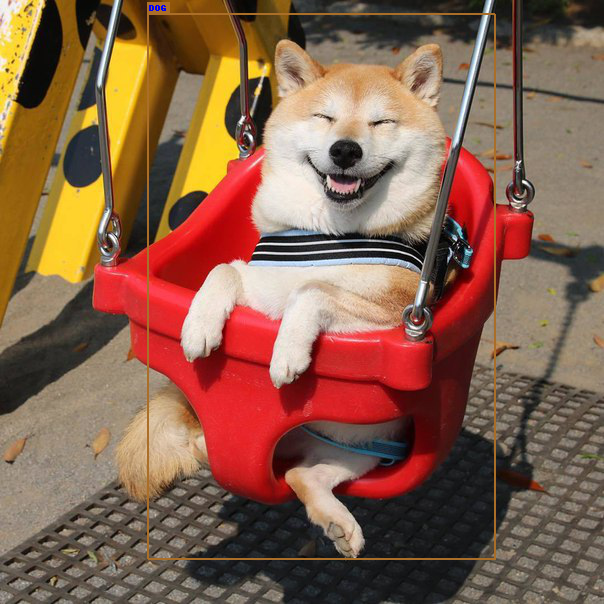

In [ ]:
draw_boxes(original_image, det_boxes, det_labels)

В целом результат посредственый -- обучен детектор на небольшой базе `Pascal VOC`, мы используем не самую сильную его версию - `ssd300`, но даже с такими вводными у нас получится сделать интересное, let's get it started. 

## Data Preparation

У нас будет небольшой набор данных из пешеходов. Данные [здесь](https://drive.google.com/file/d/1_8mnenRzV6ylr7L29LuhQHKd82GNzU9y/view?usp=sharing).














Разархивируем данные и посмотрим на изображение и соответствующие маски

In [ ]:
! unzip /content/gdrive/MyDrive/DL/PennFudanPed.zip
#! unzip PennFudanPed.zip

Archive:  /content/gdrive/MyDrive/Ozon/ML3/PennFudanPed.zip
replace __MACOSX/._PennFudanPed? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/._PennFudanPed  
  inflating: PennFudanPed/.DS_Store  
  inflating: __MACOSX/PennFudanPed/._.DS_Store  
  inflating: __MACOSX/PennFudanPed/._Images  
  inflating: __MACOSX/PennFudanPed/._Masks  
  inflating: PennFudanPed/Images/.DS_Store  
  inflating: __MACOSX/PennFudanPed/Images/._.DS_Store  
  inflating: PennFudanPed/Masks/.DS_Store  
  inflating: __MACOSX/PennFudanPed/Masks/._.DS_Store  
  inflating: PennFudanPed/Images/test/FudanPed00062.png  
  inflating: __MACOSX/PennFudanPed/Images/test/._FudanPed00062.png  
  inflating: PennFudanPed/Images/test/PennPed00071.png  
  inflating: __MACOSX/PennFudanPed/Images/test/._PennPed00071.png  
  inflating: PennFudanPed/Images/test/PennPed00065.png  
  inflating: __MACOSX/PennFudanPed/Images/test/._PennPed00065.png  
  inflating: PennFudanPed/Images/test/PennPed00070.png  
  inflating: __M

In [ ]:
def draw_image_with_mask(number):

    number_name = (5 - len(str(number)))*'0' + str(number)
    img_path = '/content/PennFudanPed/Images/train/FudanPed' + number_name + '.png'
    img_mask_path = '/content/PennFudanPed/Masks/train/FudanPed' + number_name + '_mask.png'

    original_image = Image.open(img_path) 

    original_image_mask = Image.open(img_mask_path) 

    #если не сделать преобразования ниже рисуется просто черный квадрат
    to_tensor = transforms.ToTensor()
    mask_torch = to_tensor(original_image_mask)
    mask_torch[(mask_torch != 0)] = 1

    to_pil = transforms.ToPILImage()
    img = to_pil(mask_torch)

    display(original_image)
    display(img)


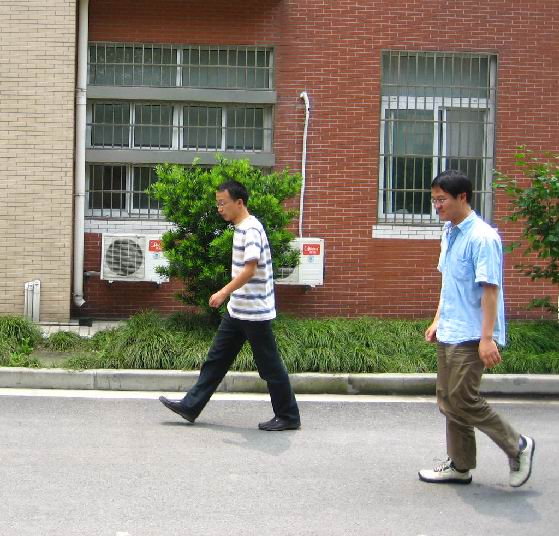

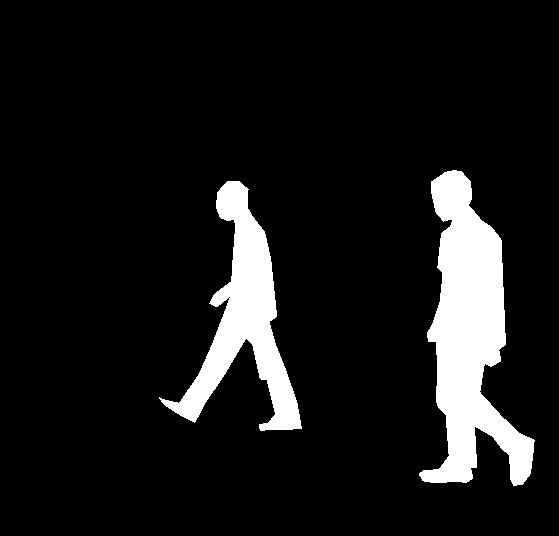

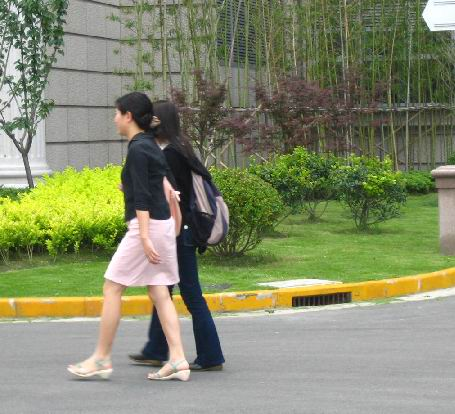

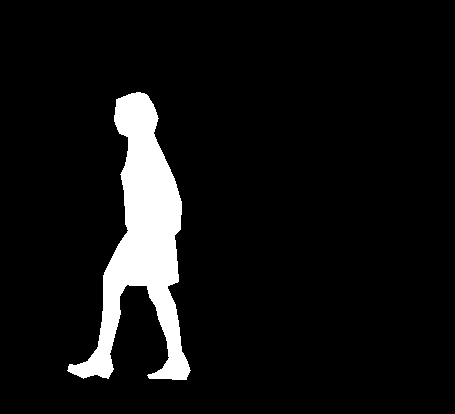

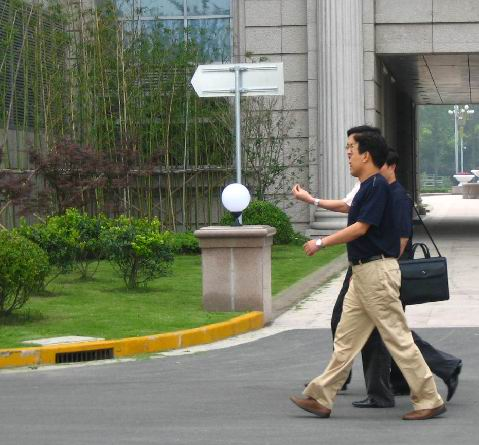

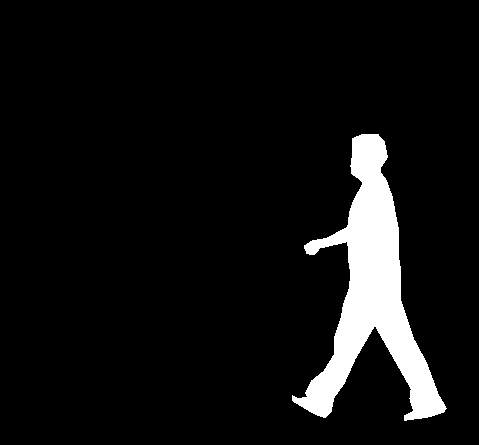

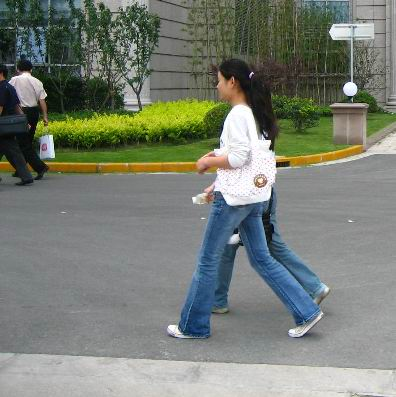

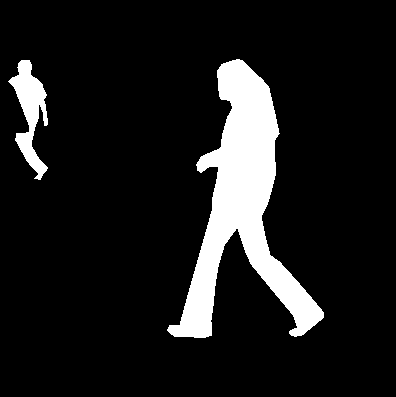

In [ ]:
for i in range(1,5):
    draw_image_with_mask(i)

In [147]:
def get_boxes_from_mask(mask_torch):
    mask_ls = []

    #можно заметить что у каждой маски разные значения, таким образом уникальные значения не считая 0 = количество масок
    n_masks = len(torch.unique(mask_torch)) - 1

    for i in range(n_masks):
        mask1 = mask_torch.clone()
        mask1[(mask1 != torch.unique(mask_torch)[i+1])] = 0
        mask1[(mask1 == torch.unique(mask_torch)[i+1])] = 1

        mask_ls.append(mask1)

    masks = torch.cat(mask_ls, dim = 0)
    boxes = torchvision.ops.masks_to_boxes(masks)

    return boxes

#просто переделаем то что было выше :)
def draw_boxes(original_image, det_boxes):
  annotated_image = original_image.copy()
  draw = ImageDraw.Draw(annotated_image)
  font = ImageFont.load_default()

  for i in range(det_boxes.size(0)):
    # Boxes
    box_location = det_boxes[i].tolist()
    draw.rectangle(xy=box_location, outline='red')

  
  return annotated_image

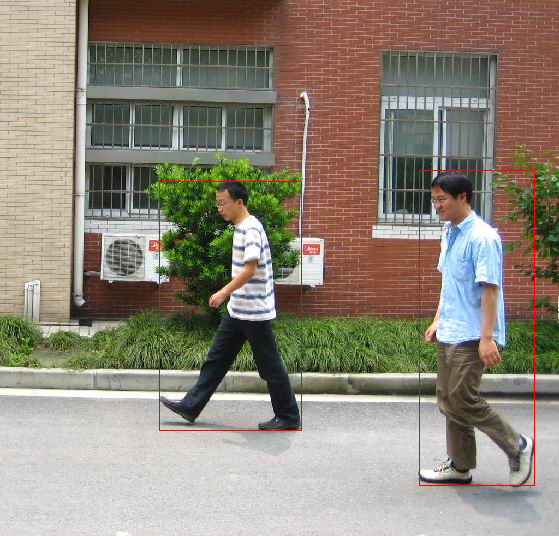

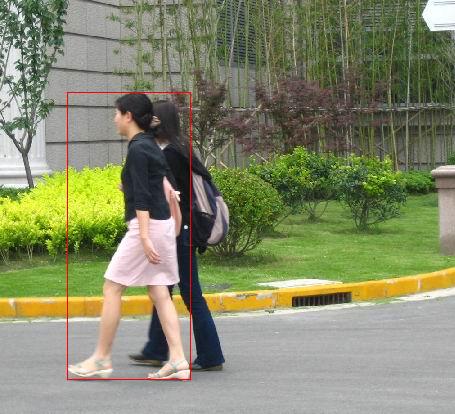

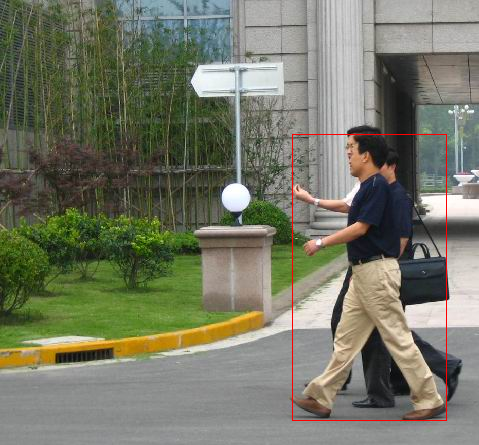

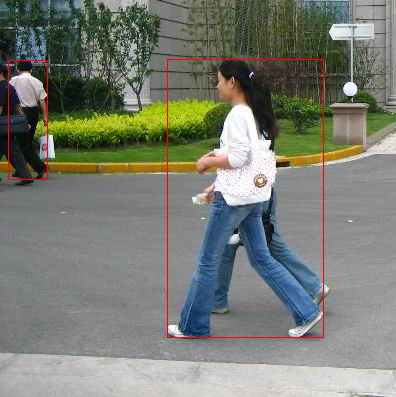

In [ ]:
for number in range(1,5):
    number_name = (5 - len(str(number)))*'0' + str(number)
    img_path = '/content/PennFudanPed/Images/train/FudanPed' + number_name + '.png'
    img_mask_path = '/content/PennFudanPed/Masks/train/FudanPed' + number_name + '_mask.png'

    original_image = Image.open(img_path) 

    original_image_mask = Image.open(img_mask_path) 


    to_tensor = transforms.ToTensor()
    mask_torch = to_tensor(original_image_mask)

    boxes = get_boxes_from_mask(mask_torch)

    img = draw_boxes(original_image, boxes)
    display(img)

Напишем `Dataset`, заведем для него загрузчики данных `DataLoader` для `train` и `test`, а далее проверим что всё работает.

In [ ]:
class PedestrianSet(object):
    def __init__(self, root, transforms, split, ped_label=15):
        self.root = root
        self.transforms = transforms
        image_filenames = sorted(glob.glob(os.path.join(root, 'Images', split, "*.png")))
        mask_filenames = sorted(glob.glob(os.path.join(root, 'Masks', split, "*.png")))
        # у нас нет аннотации, список картинок и масок надо подтянуть из root

        self.imgs = image_filenames
        self.masks = mask_filenames
        self.ped_label = ped_label

    def __getitem__(self, idx):
        # считываем картинку и маску с помощью PIL

        img = Image.open(self.imgs[idx])
        mask = Image.open(self.masks[idx])#код код теперь у нас есть маска

        

        to_tensor = transforms.ToTensor()

        img_tensor = to_tensor(img)
        w = 1/img_tensor.size()[1]
        h = 1/img_tensor.size()[2]

        mask_torch = to_tensor(mask)



        boxes = get_boxes_from_mask(mask_torch)#код код получили набор боксов соответствующий маскам

        normed_boxes = (boxes * torch.tensor([h, w, h, w]).unsqueeze(0))


        #хоть класс в данных всего один, надо верно выставить label на основании pascal voc 

        labels = torch.tensor(self.ped_label).repeat(1,boxes.size()[0]).squeeze(0) #код

        if self.transforms is not None:
            img = self.transforms(img_tensor)
        
        return img, normed_boxes, labels

    def __len__(self):
        return len(self.imgs)


def collate(batch):

    imgs = []
    labels = []
    boxes = []

    for elem in batch:
        imgs.append(elem[0])
        boxes.append(elem[1])
        labels.append(elem[2])


    imgs = torch.stack(imgs)

    #будем возвращать списками, потому что количество лейблов и боксов отличается, таким образом торчевые размерности не бьются
    return imgs, boxes, labels

In [ ]:
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([resize, normalize])

batch_size = 8

train_dataset = PedestrianSet(root='/content/PennFudanPed', transforms=transform, split='train')
test_dataset = PedestrianSet(root='/content/PennFudanPed', transforms=transform, split='test')

#train_dataset = PedestrianSet(root='PennFudanPed', transforms=transform, split='train')
#test_dataset = PedestrianSet(root='PennFudanPed', transforms=transform, split='test')


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn = collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn = collate)

In [ ]:
#посмотрим на 3 разных батча, видим что все работает, лосс нормально считается
MBloss = MultiBoxLoss(ssd.priors_cxcy)

k = 0
for batch in train_loader:
    img = batch[0]
    boxes = batch[1]
    labels = batch[2]

    locs, scores = ssd.forward(img)
    loss = MBloss.forward(locs.cuda(), scores.cuda(), boxes, labels)

    print(loss) 

    if k == 2:
        break

    k += 1

tensor(1.8127, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.6747, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.9265, device='cuda:0', grad_fn=<AddBackward0>)


## Part 2. SSD Testing

Сначала получим результат детектирования класса `person` для первоначальной модели на `pedestrian test` наборе данных. 

В интернете не нашел готовой реализации `AP` нормальной, поэтому сделаем свою

При подсчете ориентировался на статью [тут](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173)

In [ ]:
#инференс модели на изображениях из тестлоадера
all_boxes = []
all_labels = []
all_scores = []
true_boxes = []
true_labels = []

for batch in tqdm(test_loader):
    img = batch[0]
    boxes = batch[1]
    labels = batch[2]

    locs, scores = ssd.forward(img)

    det_boxes, det_labels, det_scores = ssd.detect_objects(locs.cuda(), scores.cuda(), 0.5, 0.5, 20)

    all_labels.extend(det_labels)
    all_boxes.extend(det_boxes)
    all_scores.extend(det_scores)

    true_boxes.extend(boxes)
    true_labels.extend(labels)


100%|██████████| 8/8 [00:58<00:00,  7.28s/it]


In [ ]:
#recall = tp/(tp+fn)=total gt = n
#precision = tp/(tp+fp)
def calculate_AP(det_boxes, det_labels, det_scores, true_boxes, iou_threshold, needed_label=15):
  #код
    #все скоры, боксы и тд подаются как список из тензоров. каждый элемент списка - это предсказания/gt отдельной картинки
    #вытянем все это в вектор, затем отберем только те лейблы, что нас интересуют
    #отсортируем по скорам и посчитаем 
    iou_list = []
    for i in range(len(det_boxes)):
        iou = find_jaccard_overlap(true_boxes[i].cuda(), det_boxes[i])
        overlap_for_each_prior, object_for_each_prior = iou.max(dim=0) 
        iou_list.append(overlap_for_each_prior)

    vect_scores = torch.cat(det_scores, dim=0)
    vect_labels = torch.cat(det_labels, dim=0)
    vect_iou = torch.cat(iou_list, dim=0)
    needed_labels_idx = vect_labels == needed_label

    scores_needed = vect_scores[needed_labels_idx]
    iou_needed = vect_iou[needed_labels_idx]

    scores_sorted, index_sorted = scores_needed.sort(dim=0, descending=True)

    iou_sorted = iou_needed[index_sorted]

    #print(iou_sorted)

    y_pred = (iou_sorted > iou_threshold).cpu()
    #посчитаем последовательно реколл и пресижн для каждого трешхолда по скорам если хотя бы 1 правильно предсказали
    if len(y_pred) > 0:
        recall_ls = []
        precision_ls = []
        tp = 0
        n_gt = len(y_pred)
        for i in range(y_pred.size()[0]):
            if y_pred[i]:
                tp += 1
            
            recall = tp/n_gt
            recall_ls.append(recall)

            precision = tp/(i+1)
            precision_ls.append(precision)

        precision = torch.tensor(precision_ls)
        recall = torch.tensor(recall_ls)

       # print(precision)
       # print(recall)

        ##Вначале пробовал интерполировать по 10 точкам, в итоге стал по всем реколлам достигнутым
        #recall_points = np.linspace(0,1, 11)
        recall_points = np.unique(recall)
        num_recall_points = len(recall_points)
        ap = 0
        '''
        for point in recall_points[::-1]:
            idx_more_than_point = recall>= point
          
            ap += precision[idx_more_than_point].max()
            print(ap)

        '''
        for i in range(num_recall_points-1):
            cur_point = recall_points[-(i+2)]
            prev_point = recall_points[-(i+1)]

            idx_more_than_point = recall>= cur_point
            cur_value = precision[idx_more_than_point].max()

            dist = prev_point - cur_point

            ap += cur_value * dist
    else:
        ap = 0



    return ap

In [ ]:
#подсчет метрики для класса

calculate_AP(all_boxes, all_labels, all_scores, true_boxes, 0.75)
#calculate_AP(all_boxes, all_labels, all_scores, true_boxes, true_labels, 0.75)

tensor(0.7574)

А вот теперь будем играться с моноклассовой модификацией детектора.

1. Заменим головы нашего `SSD300` так, чтобы теперь он детектировал только один класс. 

2. Подготовим код для обучения и тестирования.

3. Поэкспериментируем и постараемся выйти на хорошее качество на test - **bbox AP@IoU=0.75 >=0.75**.

In [ ]:
# возьмем рандомный батч
for batch in tqdm(test_loader):
    img = batch[0]
    boxes = batch[1]
    labels = batch[2]
    break

  0%|          | 0/8 [00:00<?, ?it/s]


In [ ]:
#в класс ssd я добавил новый метод, который меняет количества классов. По факту мы просто инициализируем новые предсказывающие головы с новым количеством классов
#при этом все предыдущие слои не меняются, таким образом, веса там остались предобученные 

#2 класса - пешеход и бекграунд
ssd.change_num_classes(2)

#img = img.to(device)

#запустим на картинке и потом посмотрим размер выхода по скорам
locs, scores = ssd.forward(img)

scores.size()

torch.Size([8, 8732, 2])

In [16]:
# Функции для сохранения и загрузки чекпоинтов
def save_checkpoint(model, filename):

    with open(filename, "wb") as fp:
        torch.save(model.state_dict(), fp)

def load_checkpoint(model, filename):

    with open(filename, "rb") as fp:
        state_dict = torch.load(fp)
    
    model.load_state_dict(state_dict)


# цикл для трейна
def run_epoch_train(model, dataloader, loss_fn, optimizer, epoch, device, scheduler=None):

    stage = 'train'

    model.train()
    torch.set_grad_enabled(True)


    model = model.to(device)
    
    losses = []
    for batch in tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}"):
        img = batch[0]
        boxes = batch[1]
        labels = batch[2]

       # img = img.to(device)
                

        locs, scores = ssd.forward(img.cuda())

        locs = locs.to(device)
        scores = scores.to(device)
        loss = loss_fn.forward(locs, scores, boxes, labels)

        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
                
        losses.append(loss.detach().cpu().item())
    
    if scheduler is not None:
        scheduler.step(np.mean(losses))


    return np.mean(losses)

# цикл для валидации
def run_epoch_val(model, dataloader, loss_fn, optimizer, epoch, device, scheduler=None):


    stage = 'val'
    torch.set_grad_enabled(False)
    model.eval()
    all_boxes = []
    all_labels = []
    all_scores = []
    true_boxes = []
    true_labels = []

    model = model.to(device)
    
    losses = []
    for batch in tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}"):
        img = batch[0]
        boxes = batch[1]
        labels = batch[2]

       # img = img.to(device)
                

        locs, scores = ssd.forward(img.cuda())

        locs = locs.to(device)
        scores = scores.to(device)
        loss = loss_fn.forward(locs, scores, boxes, labels)

        det_boxes, det_labels, det_scores = model.detect_objects(locs.cuda(), scores.cuda(), 0.5, 0.5, 10)

        all_labels.extend(det_labels)
        all_boxes.extend(det_boxes)
        all_scores.extend(det_scores)

        true_boxes.extend(boxes)
        true_labels.extend(labels)

                
        losses.append(loss.detach().cpu().item())
    

    ap = calculate_AP(all_boxes, all_labels, all_scores, true_boxes, 0.75, 1)
    print(ap)

    return np.mean(losses)

# цикл для прохождения по эпохам, обучения, валидации и логирования
def run_experiment(model, dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, output_dir, scheduler):
    
    train_losses = []
    val_losses = []

    best_val_loss = np.inf
    best_val_loss_epoch = -1
    best_val_loss_fn = None

    os.makedirs(output_dir, exist_ok=True)

    for epoch in range(num_epochs):
        train_loss = run_epoch_train(model, dataloader_train, loss_fn, optimizer, epoch, device, scheduler)
        train_losses.append(train_loss)

        val_loss = run_epoch_val(model, dataloader_val, loss_fn, optimizer, epoch, device)
        val_losses.append(val_loss)

        print(f"epoch: {str(epoch).zfill(3)} | train_loss: {train_loss:5.3f}, val_loss: {val_loss:5.3f} (best: {best_val_loss:5.3f})")

        if val_loss < best_val_loss:

            best_val_loss = val_loss
            best_val_loss_epoch = epoch

            output_fn = os.path.join(output_dir, f"epoch={str(epoch).zfill(2)}_valloss={best_val_loss:.3f}.pth.tar")
            save_checkpoint(model, output_fn)
            print(f"New checkpoint saved to {output_fn}")

            best_val_loss_fn = output_fn

        print()

    print (f"Best val_loss = {best_val_loss:.3f} reached at epoch {best_val_loss_epoch}")
   # load_checkpoint(model, best_val_loss_fn)

    return train_losses, val_losses, best_val_loss, model

In [ ]:
#здесь я перепишу датасет, чтобы он нормально работал с аугментациями


class PedestrianSet(object):
    def __init__(self, root, transforms, split, ped_label=15):
        self.root = root
        self.transforms = transforms
        image_filenames = sorted(glob.glob(os.path.join(root, 'Images', split, "*.png")))
        mask_filenames = sorted(glob.glob(os.path.join(root, 'Masks', split, "*.png")))
        # у нас нет аннотации, список картинок и масок надо подтянуть из root

        self.imgs = image_filenames
        self.masks = mask_filenames
        self.ped_label = ped_label

    def __getitem__(self, idx):
        # считываем картинку и маску с помощью PIL

        img = Image.open(self.imgs[idx])
        mask = Image.open(self.masks[idx])#код код теперь у нас есть маска



        #нормируем баундинг боксы, для чего потребуется картинка в виде тензора

        

        to_tensor = transforms.ToTensor()

        img_tensor = to_tensor(img)
        w = 1/img_tensor.size()[1]
        h = 1/img_tensor.size()[2]
       # w = 1/torch.tensor(300)
       # h = 1/torch.tensor(300)

        mask_torch = to_tensor(mask)



        boxes = get_boxes_from_mask(mask_torch)#код код получили набор боксов соответствующий маскам

        # как раз нормируем
        self.normed_boxes = (boxes * torch.tensor([h, w, h, w]).unsqueeze(0))


        #хоть класс в данных всего один, надо верно выставить label на основании pascal voc 

        #мы будем выставлять тот лейбл, который указан при инициализации класса, потому что в нашей реализации это 1 а не 15

        labels = torch.tensor(self.ped_label).repeat(1,boxes.size()[0]).squeeze(0) #код

        # а вот это нужно для албументейшнса
        named_labels = ['Pedestrian']*boxes.size()[0]

        if self.transforms is not None:

            # очередные финты ушами чтобы сделать нормальные аугментации
            # Albumentations хочет нампай, еще и с другой последовательностью каналов
            np_img = img_tensor.permute(1, 2, 0).numpy()
            np_bbox = self.normed_boxes.numpy()
            #return img_tensor.numpy(), normed_boxes.numpy(), named_labels
           # print(img_tensor.numpy().shape)
            self.transformed = self.transforms(image=np_img, bboxes=np_bbox, class_labels=named_labels)


        #а теперь возвращаем все на круги своя, в тензоры с нормальными каналами
        
        transformed_image = torch.from_numpy(self.transformed['image']).permute(2,0,1)
        transformed_bboxes = torch.tensor(self.transformed['bboxes'])

        transformed_bboxes = torch.clamp(transformed_bboxes, min=0., max=1.)
        
        return transformed_image, transformed_bboxes, labels

    def __len__(self):
        return len(self.imgs)


def collate(batch):

    imgs = []
    labels = []
    boxes = []

    for elem in batch:
        imgs.append(elem[0])
        boxes.append(elem[1])
        labels.append(elem[2])


    imgs = torch.stack(imgs)

    #будем возвращать списками, потому что количество лейблов и боксов отличается, таким образом торчевые размерности не бьются
    return imgs, boxes, labels

In [ ]:
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


#для трейна будет всячески портить картинки, самое действенное конечно - это флипы и Кроп

transform = A.Compose([
    A.Resize(300,300),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomCrop(width=300, height=300, p=0.5),
    A.AdvancedBlur(p=0.5)
], bbox_params=A.BboxParams(format='albumentations', label_fields=['class_labels'], min_visibility=0.01, min_area = 1))


test_transform = A.Compose([
    A.Resize(300,300)
], bbox_params=A.BboxParams(format='albumentations', label_fields=['class_labels'], min_visibility=0.01, min_area = 1))

#transform = transforms.Compose([to_tensor, resize])

#train_dataset = PedestrianSet(root='/content/PennFudanPed', transforms=transform, split='train', ped_label=1)
#test_dataset = PedestrianSet(root='/content/PennFudanPed', transforms=transform, split='test', ped_label=1)

train_dataset = PedestrianSet(root='PennFudanPed', transforms=transform, split='train', ped_label=1)
test_dataset = PedestrianSet(root='PennFudanPed', transforms=test_transform, split='test', ped_label=1)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn = collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn = collate)

Ниже были эксперименты со всеми головами. Вышло так себе, об этом будет дальше. В силу огромного количества экспериментов и выдачи логи убраны, но показано, что все реально обучается и не ломается

In [ ]:
lr = 3e-4
num_epochs = 2

loss_fn = MultiBoxLoss(ssd.priors_cxcy, alpha=1, neg_pos_ratio=3)
optimizer = torch.optim.Adam(ssd.parameters(), lr = lr)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=4, verbose=True, min_lr=3e-6)


for layer in ssd.base.parameters():
    layer.requires_grad = False

for layer in ssd.aux_convs.parameters():
    layer.requires_grad = False

In [ ]:
train_losses_baseline, val_losses_baseline, best_val_loss_baseline, cnn_baseline = run_experiment(
    ssd, train_loader, test_loader, loss_fn, optimizer, num_epochs, device, "base_ssd_augmented_2_bs4", scheduler
)

epoch: 000 | train: 100%|██████████| 29/29 [00:16<00:00,  1.80it/s]
epoch: 000 | val  : 100%|██████████| 15/15 [00:03<00:00,  4.85it/s]


tensor(0.1799)
epoch: 000 | train_loss: 3.909, val_loss: 2.796 (best:   inf)
New checkpoint saved to base_ssd_augmented_2_bs4/epoch=00_valloss=2.796.pth.tar



epoch: 001 | train: 100%|██████████| 29/29 [00:08<00:00,  3.31it/s]
epoch: 001 | val  : 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


tensor(0.2794)
epoch: 001 | train_loss: 3.156, val_loss: 2.457 (best: 2.796)
New checkpoint saved to base_ssd_augmented_2_bs4/epoch=01_valloss=2.457.pth.tar

Best val_loss = 2.457 reached at epoch 1


Отрежем ему голову

In [17]:
class AuxiliaryConvolutions(nn.Module):
    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()
        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0) 
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)

    def forward(self, conv7_feats):
        out = F.relu(self.conv8_1(conv7_feats)) 
        out = F.relu(self.conv8_2(out))  
        conv8_2_feats = out 

        
        out = F.relu(self.conv9_1(out))
        out = F.relu(self.conv9_2(out)) 
        conv9_2_feats = out 
        
        out = F.relu(self.conv10_1(out)) 
        out = F.relu(self.conv10_2(out))
        conv10_2_feats = out  
        '''
        out = F.relu(self.conv11_1(out))
        out = F.relu(self.conv11_2(out))
        conv11_2_feats = out
        '''

        return conv8_2_feats, conv9_2_feats, conv10_2_feats#, conv11_2_feats


class PredictionConvolutions(nn.Module):
    def __init__(self, n_classes, head_to_use=['4', '7', '82', '9_2', '10_2', '11_2']):
        super(PredictionConvolutions, self).__init__()
        self.n_classes = n_classes
        self.head_to_use = head_to_use

        n_boxes = {'conv4_3': 4, 'conv7': 6, 'conv8_2': 6,
                   'conv9_2': 6, 'conv10_2': 4, 'conv11_2': 4}



        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 4, kernel_size=3, padding=1)

        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * self.n_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * self.n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * self.n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * self.n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * self.n_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * self.n_classes, kernel_size=3, padding=1)


    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats):
        batch_size = conv4_3_feats.size(0)

        l_conv4_3 = self.loc_conv4_3(conv4_3_feats) 
        l_conv4_3 = l_conv4_3.permute(0, 2, 3, 1).contiguous()
        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)

        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)
        c_conv4_3 = c_conv4_3.permute(0, 2, 3, 1).contiguous()
        c_conv4_3 = c_conv4_3.view(batch_size, -1, self.n_classes)


        l_conv7 = self.loc_conv7(conv7_feats)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()
        l_conv7 = l_conv7.view(batch_size, -1, 4)

        c_conv7 = self.cl_conv7(conv7_feats)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()
        c_conv7 = c_conv7.view(batch_size, -1,self.n_classes)

        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)

        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)


        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)


        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()
        c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes)

        l_conv10_2 = self.loc_conv10_2(conv10_2_feats) 
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)


        c_conv10_2 = self.cl_conv10_2(conv10_2_feats)
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()
        c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes)


        '''
        if '10_2' in self.head_to_use:


        if '11_2' in self.head_to_use:
            l_conv11_2 = self.loc_conv11_2(conv11_2_feats) 
            l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()
            l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)


            c_conv11_2 = self.cl_conv11_2(conv11_2_feats)
            c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()
            c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)
        '''

        

        #locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)
        #classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2], dim=1)




        

        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2,l_conv10_2,], dim=1)
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2], dim=1)

        return locs, classes_scores



class SSD300_(nn.Module):
    def __init__(self, n_classes):
        super(SSD300_, self).__init__()
        self.n_classes = n_classes

        self.base = VGGBase()
        self.aux_convs = AuxiliaryConvolutions()
        self.pred_convs = PredictionConvolutions(self.n_classes)

        self.priors_cxcy = self.create_prior_boxes()
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1)) 
        nn.init.constant_(self.rescale_factors, 20)

    def create_prior_boxes(self):
        '''
        fmap_dims = {'conv4_3': 38, 'conv7': 19, 'conv8_2': 10,
                     'conv9_2': 5, 'conv10_2': 3, 'conv11_2': 1}

        obj_scaes = {'conv4_3': 0.1, 'conv7': 0.2, 'conv8_2': 0.375,
                      'conv9_2': 0.55, 'conv10_2': 0.725, 'conv11_2': 0.9}
        
        aspect_ratios = {'conv4_3': [1., 2., 0.5], 'conv7': [1., 2., 3., 0.5, 0.333],
                         'conv8_2': [1., 2., 3., 0.5, 0.333], 'conv9_2': [1., 2., 3., 0.5, 0.333],
                         'conv10_2': [1., 2., 0.5], 'conv11_2': [1., 2., 0.5]}
        '''
        fmap_dims = {'conv4_3': 38, 'conv7': 19, 'conv8_2': 10,
                     'conv9_2': 5, 'conv10_2': 3}

        obj_scales = {'conv4_3': 0.1, 'conv7': 0.2, 'conv8_2': 0.375,
                      'conv9_2': 0.55, 'conv10_2': 0.725}
        
        aspect_ratios = {'conv4_3': [1., 2., 0.5], 'conv7': [1., 2., 3., 0.5, 0.333],
                         'conv8_2': [1., 2., 3., 0.5, 0.333], 'conv9_2': [1., 2., 3., 0.5, 0.333],
                         'conv10_2': [1., 2., 0.5]}

        prior_boxes = []
        fmaps = list(fmap_dims.keys())

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]): 
                for j in range(fmap_dims[fmap]): 
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])

                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)
        prior_boxes.clamp_(0, 1)
        return prior_boxes

    def forward(self, image):
      conv4_3_feats, conv7_feats = self.base(image)  

      norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()
      conv4_3_feats = conv4_3_feats / norm 
      conv4_3_feats = conv4_3_feats * self.rescale_factors  

      conv8_2_feats, conv9_2_feats, conv10_2_feats = self.aux_convs(conv7_feats)  

      locs, classes_scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats)

      return locs, classes_scores


    def change_num_classes(self, new_n_classes):
        self.n_classes = new_n_classes
        self.pred_convs = PredictionConvolutions(self.n_classes)

class SSD300(SSD300_):
  def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)

        predicted_scores = F.softmax(predicted_scores, dim=2)

        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            decoded_locs = cxcy_to_xy(gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))

            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1) 

            for c in range(1, self.n_classes):
                class_scores = predicted_scores[i][:, c]
                score_above_min_score = class_scores > min_score 
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
 
                class_scores = class_scores[score_above_min_score] 
                class_decoded_locs = decoded_locs[score_above_min_score] 

                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  
                class_decoded_locs = class_decoded_locs[sort_ind] 

                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  

                # Non-Maximum Suppression (NMS)
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)

                for box in range(class_decoded_locs.size(0)):
                    if suppress[box] == 1:
                        continue

                    suppress = suppress | (overlap[box] > max_overlap)
                    suppress[box] = 0

                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                image_scores.append(class_scores[1 - suppress])

            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))

            image_boxes = torch.cat(image_boxes, dim=0) 
            image_labels = torch.cat(image_labels, dim=0)
            image_scores = torch.cat(image_scores, dim=0) 
            n_objects = image_scores.size(0)

            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k] 
                image_boxes = image_boxes[sort_ind][:top_k] 
                image_labels = image_labels[sort_ind][:top_k] 

            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores 

Чтобы по нормальному все смэтчить с предобученными весами сначала инициализируем модель как в предобученном случае. Затем найдем те ключи которые есть в нашей модели, их оставим и сметчим. И затем применим функцию, о которой я говорил выше, где мы заменим свертки предсказывающие на необходимые нам, с нужным числом классов

In [18]:
# Вдохновлено https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113


ssd = SSD300(21)

pretrained_dict = checkpoint['state_dict']
model_dict = ssd.state_dict()

# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
# 3. load the new state dict
ssd.load_state_dict(pretrained_dict)
ssd.change_num_classes(2)


 Loaded backbone.



In [19]:
# проверим что все окей. Тут видно некоторые свертки, которые мы не используем, главное проверить число каналов на выходе

ssd

SSD300(
  (base): VGGBase(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), 

In [ ]:
lr = 3e-4
#num_epochs = 120
num_epochs=2

loss_fn = MultiBoxLoss(ssd.priors_cxcy, alpha=1, neg_pos_ratio=3)
optimizer = torch.optim.Adam(ssd.parameters(), lr = lr)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=4, verbose=True, min_lr=3e-6)


for layer in ssd.base.parameters():
    layer.requires_grad = False

for layer in ssd.aux_convs.parameters():
    layer.requires_grad = False

In [ ]:
train_losses_baseline, val_losses_baseline, best_val_loss_baseline, cnn_baseline = run_experiment(
    ssd, train_loader, test_loader, loss_fn, optimizer, num_epochs, device, "base_ssd_augmented_bs4_heads_4_7_8_9_10", scheduler
)

epoch: 000 | train: 100%|██████████| 29/29 [00:08<00:00,  3.31it/s]
epoch: 000 | val  : 100%|██████████| 15/15 [00:02<00:00,  5.24it/s]


tensor(0.0786)
epoch: 000 | train_loss: 3.894, val_loss: 2.815 (best:   inf)
New checkpoint saved to base_ssd_augmented_bs4_heads_4_7_8_9_10/epoch=00_valloss=2.815.pth.tar



epoch: 001 | train: 100%|██████████| 29/29 [00:08<00:00,  3.30it/s]
epoch: 001 | val  : 100%|██████████| 15/15 [00:02<00:00,  5.30it/s]


tensor(0.3816)
epoch: 001 | train_loss: 3.163, val_loss: 2.453 (best: 2.815)
New checkpoint saved to base_ssd_augmented_bs4_heads_4_7_8_9_10/epoch=01_valloss=2.453.pth.tar

Best val_loss = 2.453 reached at epoch 1


In [ ]:
#num_epochs = 350
num_epochs = 2
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=6, verbose=True, min_lr=3e-7)
for g in optimizer.param_groups:
    g['lr'] = 3e-5


for layer in ssd.base.parameters():
    layer.requires_grad = True

for layer in ssd.aux_convs.parameters():
    layer.requires_grad = True

In [ ]:
train_losses_baseline, val_losses_baseline, best_val_loss_baseline, cnn_baseline = run_experiment(
    ssd, train_loader, test_loader, loss_fn, optimizer, num_epochs, device, "base_ssd_augmented_bs4_heads_4_7_8_9_10", scheduler
)

epoch: 000 | train: 100%|██████████| 29/29 [00:10<00:00,  2.66it/s]
epoch: 000 | val  : 100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


tensor(0.4467)
epoch: 000 | train_loss: 2.833, val_loss: 2.272 (best:   inf)
New checkpoint saved to base_ssd_augmented_bs4_heads_4_7_8_9_10/epoch=00_valloss=2.272.pth.tar



epoch: 001 | train: 100%|██████████| 29/29 [00:12<00:00,  2.25it/s]
epoch: 001 | val  : 100%|██████████| 15/15 [00:04<00:00,  3.18it/s]


tensor(0.5438)
epoch: 001 | train_loss: 2.615, val_loss: 2.225 (best: 2.272)
New checkpoint saved to base_ssd_augmented_bs4_heads_4_7_8_9_10/epoch=01_valloss=2.225.pth.tar

Best val_loss = 2.225 reached at epoch 1


In [20]:
load_checkpoint(ssd, '/content/gdrive/MyDrive/DL/epoch=30_valloss=1.426.pth.tar')

In [ ]:
#инференс модели на изображениях из тестлоадера
all_boxes = []
all_labels = []
all_scores = []
true_boxes = []
true_labels = []

ssd.eval()

for batch in tqdm(test_loader):

    
    img = batch[0]
    boxes = batch[1]
    labels = batch[2]


    locs, scores = ssd.forward(img.cuda())

    det_boxes, det_labels, det_scores = ssd.detect_objects(locs.cuda(), scores.cuda(), 0.7, 0.6, 50)

    all_labels.extend(det_labels)
    all_boxes.extend(det_boxes)
    all_scores.extend(det_scores)

    true_boxes.extend(boxes)
    true_labels.extend(labels)


calculate_AP(all_boxes, all_labels, all_scores, true_boxes, 0.75, 1)

100%|██████████| 15/15 [00:03<00:00,  4.90it/s]


tensor(0.8501)

# Итого

Пойдем по порядку.
1) результат лучше, на 10 пунктов, AP на классе пешехода 0.85 при 0.75 IOU

2) Дополнительная настройка сильно улучшила модель для предсказания требуемого класса

А также

1) не стоит менять параметры у лосса, увеличение значимости баундинг бокса вначале дает лучше результат но потом быстро становится хуже.

2) так же не стоит менять количество негативных примеров, если их снижать, то модель становилась хуже

3) не стоит обучать сразу все слои

4) очень помогли аугментации. аугментации с поворотами и отражениями классные, изменение цвета тоже, но как будто бы меньше. А еще албументейшнс думает что каналы должны стоять на 3 месте а не на 1, к сожалению на этом много проковырялся

5) выходит лучше если сначала заморозить Aux свертки и свертки от VGG и обучать только предсказывающие головы

6) если потом и размораживать, то все сразу, тогда выходит намного лучше

7) без шедулеров тоже было бы плохо, в начале лосс убывает достаточно быстро, но потом приходилось понижать темп аж до 3e-7, потому что батчи маленькие, а сеть достаточно глубокая

8) чем больше голов тем лучше. пробовал отдельно 4,7,8 головы, потом 4,7,8,9 головы и вот этот результат на 4,7,8,9,10


## Part 3. Video Detection

Давайте теперь сделаем классный видеоролик. Видео  живет тут: https://www.epfl.ch/labs/cvlab/data/data-pom-index-php/

Берем оттуда **Campus sequences - [Seq.1, cam. 1].**

Пишем `Dataset` для видеопоследовательности. Он будет иметь метод не `get_item`, а `iter`, так как по последовательности мы хотим пройти один раз и каждый кадр отправлять в сетку. Можно использовать и обычный `Dataset`, но для `get_item` нам надо уметь получать видеокадр по конкретному индексу из видеопоследовательности, для `VideoCapture` этот метод работает плохо (возможны неточные выдергивания).

Далее прогоняем картинки через сетку и для кадров собираем результаты детектирования.

Пробегаем по последовательности ещё раз, рисуем на кадрах боксы, собираем всё в видео.


In [21]:
from itertools import compress

In [140]:
class VideoSet(torch.utils.data.IterableDataset):
    """Dataset based on video file"""
    def __init__(self, video_path, transform):
        self.cap = cv2.VideoCapture(video_path)
        self.transform = transform

    def __iter__(self):
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, 0) #поставили указатель начала чтения на самое начало
        self.total_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_id = 0 

        while True:
            status, image = self.cap.read()

            if not status:
                break

            #перегоняем в формат ргб, потому что в таком формате мы читали изображения когда учили детектор, а cv2 воспринимает его в BGR
            # потому что читали мы с помощью PIL-а
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = self.transform(image)
            frame_id += 1

            yield (frame_id, image)

            #а ещё frame_id надо менять если id нужен

In [141]:
to_tensor = transforms.ToTensor()
resize = transforms.Resize((300,300))
to_pil = transforms.ToPILImage()

transform = transforms.Compose([to_tensor, resize])

path = '/content/gdrive/MyDrive/Ozon/ML3/campus4-c1.avi'


Dataset = VideoSet(path, transform)

BS = 1 

loader = DataLoader(Dataset, batch_size=BS, shuffle=False, num_workers=0)

ssd = ssd.to(device)

In [1]:
#прогоняем каждый фрейм через сеть

In [160]:
with torch.no_grad():
    all_boxes = []
    for batch in tqdm(loader):
        frame_id, image = batch

        image = image.to(device)
        locs, scores = ssd.forward(image)
        del image
        det_boxes, det_labels, det_scores = ssd.detect_objects(locs.cuda(), scores.cuda(), 0.3, 0.5, 20)

        del locs
        del scores

        #отбираем боксы только для лейбла пешехода
        idx_ped = det_labels[0] == 1
        needed_boxes = list(compress(det_boxes, idx_ped))

        #может и никого не быть
        if len(needed_boxes) > 0:
            tensor_boxes = torch.cat(needed_boxes)
        else:
            tensor_boxes = torch.tensor([])

        all_boxes.append(tensor_boxes)

1801it [00:36, 49.09it/s]


In [2]:
#тут с помощью cv2.VideoCapture снова прочитаем видео, нарисуем результаты на фреймах

In [162]:
pics = []
k = 0
l = 0
for batch in tqdm(loader):
    frame_id, image = batch
    box = all_boxes[frame_id - 1]
    
    if box.size()[0] > 0:
        box_orig = box.cpu() * torch.tensor([300,300,300,300])
    else:
        box_orig = box

    pil_image = to_pil(image[0])
    img = draw_boxes(pil_image, box_orig)
    #np_img = np.asarray(img)
    pics.append(img)


1801it [00:11, 161.53it/s]


In [164]:
def pil_to_cv(pil_image):
    #теперь надо перегнать обратно, потому что видос мы собираем в формате CV2
    opencvImage = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    #opencvImage = np.array(pil_image)
    return opencvImage

# источник вдохновения https://www.programcreek.com/python/example/72134/cv2.VideoWriter
def write_video(file_path, frames, fps):

    """
    Writes frames to an mp4 video file
    :param file_path: Path to output video, must end with .mp4
    :param frames: List of PIL.Image objects
    :param fps: Desired frame rate
    """

    w, h = frames[0].size
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    writer = cv2.VideoWriter(file_path, fourcc, fps, (w, h))

    for frame in frames:
        writer.write(pil_to_cv(frame))

    writer.release() 

In [165]:
path = '/content/gdrive/MyDrive/DL/my_detector9.mp4'
write_video(path, pics, 25)

Посмотреть можно [здесь](https://drive.google.com/file/d/1-LCZ5jTjxX7uchWC4i7IGJTSzo9flUvi/view?usp=sharing)

## Object Tracking

Вспоминаем, что у нас ходят отдельные люди - сделаем простенький object tracking, где боксы соседних фреймов относятся к одному треку по IoU детекций.

Идея проста - если на фреймах `N+0` и `N+1` `IoU` двух боксов `> threshold`, то считаем что трек остался тот же - и для него сохраняем цвет визуализации бокса с фрейма `N`, если нет - заводим новый цвет. И учитываем что бокс может совпасть только с ОДНИМ боксом с предыдущего кадра. Процедура ровно та же что в детекторе спрятана. 

Для тех же боксов и масок нарисуем ещё одно видео - где каждый человек будет иметь **один** цвет **от начала до конца** своего присутствия в видео (фактически мы получим трек конкретного человека). 


In [166]:
# Создадим пары, в котором у каждого бокса есть свой цвет
all_boxes_with_color = []
for boxes in all_boxes:
    all_boxes_with_color.append((boxes.cpu(), [-1]*boxes.size()[0]))

In [167]:
distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4', '#46f0f0', '#f032e6',
                   '#d2f53c', '#fabebe', '#008080', '#000080', '#aa6e28', '#fffac8', '#800000', '#aaffc3', '#808000',
                   '#ffd8b1', '#e6beff', '#808080', '#FFFFFF']
free_colors = collections.deque(list(range(len(distinct_colors))))

#возьмем набор разных цветов, а также сделаем очередь. Если бокс имеет новый цвет - достаем первый цвет в очереди, если бокс не сметчился, то его цвет встает в конец очереди

In [168]:
#тут добавилась функция матчинга по IoU

def match_box(boxes_with_colors, prev_boxes_with_colors, threshold):

    #очередь свободных цветов
    global free_colors


    # ищем пересечение, берем максимум и делаем бул больше ли трешхолда
    iou = find_jaccard_overlap(boxes_with_colors[0], prev_boxes_with_colors[0])
    overlap_for_each_box, object_for_each_box = iou.max(dim=1)
    overlap_more_thr = overlap_for_each_box > threshold

    # здесь будем хранить индексы для которых сматчились
    # если получится так что у нас 1 новый бокс и 2 старых, тогда 1 останется несметченный и надо с него выкинуть цвет
    matched_boxes = []

    # ну а теперь перебираем цвета каждого бокса и если они преодолели порог то присваиваем цвет предыдущего бокса
    for i in range(boxes_with_colors[0].size()[0]):
        # берем матченный по максимуму бокс 
        matched_index = object_for_each_box[i].item()
        prev_color = prev_boxes_with_colors[1][matched_index]
        #запишем в индексы которые мы сматчили, по которому ниже принимаем решение
        matched_boxes.append(matched_index)
        #print(overlap_more_thr[i])
        if overlap_more_thr[i]:
            boxes_with_colors[1][i] = prev_color
        else:
            boxes_with_colors[1][i] = free_colors.pop()
            #print(prev_color)
            free_colors.appendleft(prev_color)

    #будем выкидывать то что не сматчилось
    for i in range(len(prev_boxes_with_colors[1])):
        if i not in matched_boxes:
            color = prev_boxes_with_colors[1][i]
            free_colors.appendleft(color)

def set_colors(box, prev_box, threshold):

    #если текущий бокс пустой, то выкидываем все с прошлого в свободные цвета, потому что оно теперь не сматчится точно
    if box[0].size()[0] == 0:
       # print(prev_box)
        #Если там что-то есть то уже будет что-то делать, иначе просто ничего не делаем
        if prev_box[0].size()[0] > 0:
            for i in range(len(prev_box[1])):
                #print(2)
                prev_color = prev_box[1][i]
                free_colors.appendleft(prev_color)

    else:
      #  print(prev_box)
        #иначе наш бокс не пустой, проверим если прошлый не пустой, то матчим и меняем цвета
        if prev_box[0].size()[0] > 0:
           # print(1)
            match_box(box, prev_box, threshold)
        
        #если же текущий не пустой, а прошлый пустой, то надо просто присвоить свободные цвета
        else:
           # print(3)
            for i in range(len(box[1])):
                box[1][i] = free_colors.pop()


In [169]:
for i in tqdm(range(len(all_boxes_with_color)-1)):
    prev_box = all_boxes_with_color[i]
    boxes = all_boxes_with_color[i+1]

   # print(prev_box, boxes, i)
   # обьявим небольшой трешхолд, иначе получается не очень 
    threshold = 0.5

    set_colors(boxes, prev_box, threshold)

    all_boxes_with_color[i] = prev_box
    all_boxes_with_color[i+1] = boxes 

100%|██████████| 1800/1800 [00:00<00:00, 10679.02it/s]


In [171]:
# Приделаем к бывшей функции рисования поддержку цветов
def draw_boxes_color(original_image, boxes_with_colors):

  global distinct_colors
  
  annotated_image = original_image.copy()
  draw = ImageDraw.Draw(annotated_image)
  font = ImageFont.load_default()

  det_boxes = boxes_with_colors[0] 

  colors = boxes_with_colors[1]

  for i in range(det_boxes.size(0)):
    # Boxes
    box_location = det_boxes[i].tolist()

    outline_color_idx = colors[i]
    outline_color = distinct_colors[outline_color_idx]
    draw.rectangle(xy=box_location, outline=outline_color)

  
  return annotated_image

In [ ]:
#а тут снова читаем видео, рисуем на фреймах боксы и маски учитывая их положения на предыдущем кадре и соответственно выбирая цвет, собираем новое видео

In [174]:
pics = []
k = 0
l = 0
for batch in tqdm(loader):
    frame_id, image = batch

    box = all_boxes_with_color[frame_id - 1]
    box = all_boxes_with_color[frame_id - 1]
    
    if box[0].size()[0] > 0:
        orig_box = (box[0] * torch.tensor([300,300,300,300]), box[1])
    else:
        orig_box = box


    pil_image = to_pil(image[0])
    img = draw_boxes_color(pil_image, orig_box)
    #np_img = np.asarray(img)
    pics.append(img)

1801it [00:16, 107.52it/s]


In [176]:
path = '/content/gdrive/MyDrive/DL/my_detector_colored2.mp4'
write_video(path, pics, 30)

Посмотреть можно [здесь](https://drive.google.com/file/d/1-__DLRZBYsaJj8KmVMayVrUYXvbt4Kc5/view?usp=sharing)


